In [1]:
from numpy import *
from matplotlib.pyplot import *
import scipy.linalg

In [2]:
trainLen = 2000 #cuanto dura
testLen = 2000
initLen = 100 #a que tiempo empezar

data = loadtxt('MackeyGlass_t17.txt') #Se importa como un numpy array
print(data)

[ 0.122064    0.04719682 -0.01833035 ..., -0.17013491 -0.13728365
 -0.10034541]


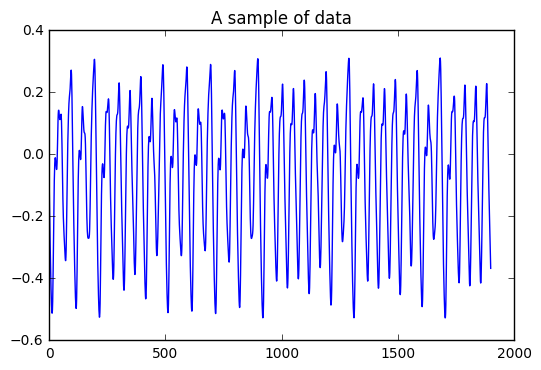

In [3]:
figure(10).clear()
plot(data[initLen+1:trainLen+1])
title('A sample of data')
show()

In [4]:
###########################################################################
#
# Generate the ESN reservoir
# 
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# generate the ESN reservoir
inSize = outSize = 1
resSize = 207
a = 0.3 # leaking rate

#crear la Win, la matriz que va a interaccionar los nodos in 
random.seed(42)
Win = (random.rand(resSize,1+inSize)-0.5) * 1
print(Win)

[[-0.12545988  0.45071431]
 [ 0.23199394  0.09865848]
 [-0.34398136 -0.34400548]
 [-0.44191639  0.36617615]
 [ 0.10111501  0.20807258]
 [-0.47941551  0.46990985]
 [ 0.33244264 -0.28766089]
 [-0.31817503 -0.31659549]
 [-0.19575776  0.02475643]
 [-0.06805498 -0.20877086]
 [ 0.11185289 -0.36050614]
 [-0.20785535 -0.13363816]
 [-0.04393002  0.28517596]
 [-0.30032622  0.01423444]
 [ 0.09241457 -0.45354959]
 [ 0.10754485 -0.32947588]
 [-0.43494841  0.44888554]
 [ 0.46563203  0.30839735]
 [-0.19538623 -0.40232789]
 [ 0.18423303 -0.05984751]
 [-0.37796177 -0.00482309]
 [-0.46561148  0.4093204 ]
 [-0.24122002  0.16252228]
 [-0.18828892  0.02006802]
 [ 0.04671028 -0.31514554]
 [ 0.46958463  0.27513282]
 [ 0.43949894  0.39482735]
 [ 0.09789998  0.42187424]
 [-0.4115075  -0.30401714]
 [-0.45477271 -0.17466967]
 [-0.11132271 -0.22865097]
 [ 0.32873751 -0.14324667]
 [-0.21906549  0.04269608]
 [-0.35907578  0.30219698]
 [-0.42544936  0.48688694]
 [ 0.27224477 -0.30128432]
 [-0.49447788  0.31546143]
 

In [5]:
##QUE ES EL SPECTRAL RADIUS

W = random.rand(resSize,resSize)-0.5 

# normalizing and setting spectral radius (correct, slow):
rhoW = max(abs(linalg.eig(W)[0]))
W *= 1.25 / rhoW
print(rhoW)

4.41796189242


In [6]:
###########################################################################
#
# Run the reservoir with the data and collect X.
# 
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#x es una matriz The X matrix is like a complete history of the reservoir activations (which are the states). 
#You are transforming your input space into this new state space.
X = zeros((1+inSize+resSize,trainLen-initLen))
print(X)
# set the corresponding target matrix directly

Yt = data[None,initLen+1:trainLen+1] 
print(Yt)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[-0.09351762 -0.14571328 -0.19540772 ..., -0.30151187 -0.33570312
  -0.36746866]]


In [7]:
x = zeros((resSize,1)) #Initialize a vector with the size of a reservoir
for t in range(trainLen): #así tienes desde t=0, hasta t=1999
    u = data[t]
    x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) ) #Update equation of a RRN with leaky-integrated discre-time values units.
    if t >= initLen: #cuando lleguemos al incio del training, empieza a guardarme en X, mi conjunto de states, un vector que concatene 1 (el bias), el input y la activacion
        X[:,t-initLen] = vstack((1,u,x))[:,0]
        #Because the network makes its predictions based not only on the current state, but also on the current input (and yes, the 1 is the bias).
        #It is something like "if I'm on this situation (X) and do that (input), what happens (output)?"

In [8]:
###########################################################################
#
# Train the output
# 
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

reg = 1e-8  # regularization coefficient
X_T = X.T
Wout = dot( dot(Yt,X_T), linalg.inv( dot(X,X_T) + reg*eye(1+inSize+resSize) ) ) #w= y*x_t*(x*x_t + beta*I)^-1

In [9]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# 
# Run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
# 
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Y = zeros((outSize,testLen))
u = data[trainLen]
for t in range(testLen):
    x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) )
    y = dot( Wout, vstack((1,u,x)) )
    Y[:,t] = y
    # generative mode:
    u = y  
    ## this would be a predictive mode:
    #u = data[trainLen+t+1] 



In [10]:
# compute MSE for the first errorLen time steps
errorLen = 500
mse = sum( square( data[trainLen+1:trainLen+errorLen+1] - Y[0,0:errorLen] ) ) / errorLen
print('MSE = ' + str( mse ))

MSE = 0.00116968363618


In [11]:
# plot some signals
figure(1).clear()
plot( data[trainLen+1:trainLen+testLen+1], 'g' )
plot( Y.T, 'b' )
title('Target and generated signals $y(n)$ starting at $n=0$')
legend(['Target signal', 'Free-running predicted signal'])

figure(2).clear()
plot( X[0:20,0:200].T )
title('Some reservoir activations $\mathbf{x}(n)$')

figure(3).clear()
bar( range(1+inSize+resSize), Wout.T )
title('Output weights $\mathbf{W}^{out}$')

show()

/usr/lib/python3/dist-packages/matplotlib/ticker.py:1424: RuntimeWarning: invalid value encountered in double_scalars
  extra_bins = int(divmod((best_vmax - vmax), step)[0])


ValueError: cannot convert float NaN to integer

In [ ]:
print( X[0:20,0:200])